## Customer Segmentation

This workbook is to segement the customers with various info into several clusters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import metrics

aisle_path = 'E:\Sebnewrepo\Data/aisles.csv'
aisles = pd.read_csv(aisle_path)

departments_path = 'E:\Sebnewrepo\Data/departments.csv'
departments = pd.read_csv(departments_path)

order_products_path = 'E:\Sebnewrepo\Data/order_products.csv'
order_products = pd.read_csv(order_products_path)

orders_path = 'E:\Sebnewrepo\Data/orders.csv'
orders = pd.read_csv(orders_path)

products_path = 'E:\Sebnewrepo\Data/products.csv'
products = pd.read_csv(products_path)

#### 01. Users and Aisles

In [2]:
joint = order_products.merge(orders, on = 'order_id', how = 'left')
joint = joint.merge(products, on = 'product_id', how = 'left')
joint.head()

,order_id,product_id,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,202279,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,202279,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,202279,3,5,9,8.0,Garlic Powder,104,13
3,2,45918,4,202279,3,5,9,8.0,Coconut Butter,19,13
4,2,30035,5,202279,3,5,9,8.0,Natural Sweetener,17,13


In [3]:
df_joint = pd.DataFrame({
    'users_id' : joint['user_id'],
    'aisle_id' : joint['aisle_id']
})
df_joint01 = df_joint.merge(aisles, on = 'aisle_id', how = 'left')
df_joint01.head()

,users_id,aisle_id,aisle
0,202279,86,eggs
1,202279,83,fresh vegetables
2,202279,104,spices seasonings
3,202279,19,oils vinegars
4,202279,17,baking ingredients


In [4]:
#pivot the table:
#df_joint02 = df_joint01.drop(['aisle_id'], axis = 1)
new_df = pd.pivot_table(df_joint01, 
                   index = ['users_id'],
                   columns = ['aisle'],
                   aggfunc = 'count')
new_df = new_df.fillna(0)
new_df.head()

aisle_id                               \
aisle    air fresheners candles asian foods baby accessories   
users_id                                                       
1                           0.0         0.0              0.0   
2                           0.0         3.0              0.0   
3                           0.0         0.0              0.0   
4                           0.0         0.0              0.0   
5                           1.0         4.0              0.0   

                                                                \
aisle    baby bath body care baby food formula bakery desserts   
users_id                                                         
1                        0.0               0.0             0.0   
2                        0.0               0.0             0.0   
3                        0.0               0.0             0.0   
4                        0.0               0.0             0.0   
5                        0.0               0.0             0.0   

                                                                        ...  \
aisle    baking ingredients baking supplies decor beauty beers coolers  ...   
users_id                                                                ...   
1                       0.0                   0.0    0.0           0.0  ...   
2                       2.0                   0.0    0.0           0.0  ...   
3                       0.0                   0.0    0.0           0.0  ...   
4                       0.0                   0.0    0.0           0.0  ...   
5                       0.0                   0.0    0.0           0.0  ...   

                                                                   \
aisle    spreads  tea tofu meat alternatives tortillas flat bread   
users_id                                                            
1            1.0  0.0                    0.0                  0.0   
2            3.0  1.0                    1.0                  0.0   
3            4.0  1.0                    0.0                  0.0   
4            0.0  0.0                    0.0                  1.0   
5            0.0  0.0                    0.0                  0.0   

                                                                     \
aisle    trail mix snack mix trash bags liners vitamins supplements   
users_id                                                              
1                        0.0               0.0                  0.0   
2                        0.0               0.0                  0.0   
3                        0.0               0.0                  0.0   
4                        0.0               0.0                  0.0   
5                        0.0               0.0                  0.0   

                                                           
aisle    water seltzer sparkling water white wines yogurt  
users_id                                                   
1                                  0.0         0.0    2.0  
2                                  2.0         0.0   42.0  
3                                  2.0         0.0    0.0  
4                                  1.0         0.0    0.0  
5                                  0.0         0.0    3.0  

[5 rows x 134 columns]

Try PCA here to reduct the demension

In [49]:
def pca_process(n, df):
    pca = decomposition.PCA(n_components = n)
    pca_data = pca.fit_transform(df)

    ## get PCs, show Explained variance per principal component
    pca_df = pd.DataFrame(pca_data)
    print('Explained variance per principal component:',pca.explained_variance_ratio_)
    
    ss = StandardScaler()
    pca_df1 = pd.DataFrame(ss.fit_transform(pca_df))
    return pca_df1

In [59]:
##Try n = 2
pca_data1 = pca_process(2, new_df)

Explained variance per principal component: [0.4786378  0.09640584]


In [60]:
##Try n = 3
pca_data2 = pca_process(3, new_df)

Explained variance per principal component: [0.4786378  0.09640584 0.05210072]


The dataframe is ready here to segment

Try Kmeans to cluster the data

In [64]:
def kmeans(k, df):
    kmeans = KMeans(n_clusters = k, random_state=0)
    kmeans.fit(df)
    y_kmeans = kmeans.fit_predict(df)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return (y_kmeans, centers, labels)

# CH Score Check
def CH_Score(df):
    i = []
    CH_score = []
    max_k = len(pca_data1.index)
    for k in range(2,10):
        y_kmeans, centers, labels = kmeans(k,df)
        m = metrics.calinski_harabasz_score(df, labels)
        i.append(k)
        CH_score.append(m)

    plt.figure()  
    plt.plot(i,CH_score)  
    plt.xlabel("kmeans-k")  
    plt.ylabel("calinski_harabaz_score")  
    plt.title("Performance of K") 
    return

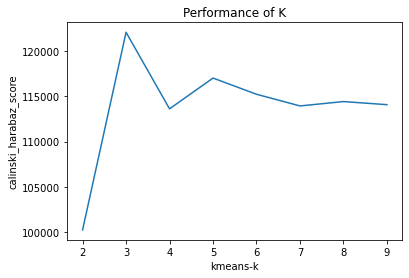

In [62]:
# Use 2 demension data First
CH_Score(pca_data1)

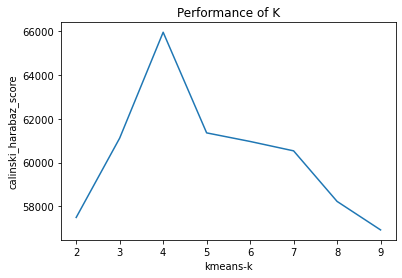

In [63]:
# Use 3 demension data
CH_Score(pca_data2)

According to the figures, if demension = 2, the 3 clusters is the best solution. If demension = 3, the 4 cluster is the best solution.

Plot these two result

In [ ]:
# n = 2, k = 3
pca_df = kmeans(3, pca_data1)
pca_output = pd.DataFrame({
    'PC1':pca_df['PC1'],
    'PC2':pca_df['PC2'],
    'label':breast_dataset['label']
})
output = sns.relplot(x="PC1", y="PC2", hue="label", data=pca_output)